In [1]:
import numpy as np
import xarray as xr
import itertools
import matplotlib.pyplot as plt
from cartopy import geodesic
import cartopy.crs as ccrs
import shapely
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import analysis_functions as funk
import cartopy.feature as cfeature
from cycler import cycler

from scipy.stats import kde

In [2]:
initial_depth = -5100  # int(sys.argv[1])  # 5 # 60 # 5179
lon_sample = 6.287  # 6.25
lat_sample = -32.171  # -32.171
origin = (lon_sample, lat_sample)

start_time = datetime.strptime('2019-01-20 12:00:00', '%Y-%m-%d %H:%M:%S')
sim_time = 4484
# create the date range in reverse from sampling time to the past
datelist = pd.date_range(end=start_time, periods=sim_time)[::-1]
end_time = datelist[0]

# simulations = [10] + [i for i in range(100, 501, 100)]
simulations = [500, 1000, 10000, 23000]

In [3]:
surface_events = np.load('../data/surface_events.npy', allow_pickle=True).item()
surface_events

{500: {'particle_index': array([   0,    1,    2, ..., 8189, 8190, 8191]),
  'surface_time': array([1766, 1364, 3028, ..., 1248, 1336,  767]),
  'radius': array([2.70144297e-05, 3.17771313e-05, 9.54072839e-05, ...,
         1.17324191e-04, 4.54980597e-05, 1.44773562e-04]),
  'depths': array([3.35872992, 8.30761344, 0.712733  , ..., 9.        , 0.42902467,
         9.        ]),
  'displacement': array([1166947.83957413,  248955.78880167,  596581.67783603, ...,
          834026.26358606, 1244816.4021016 ,  512608.05231838]),
  'lat': array([-37.37389978, -33.36070869, -30.75592446, ..., -38.31911217,
         -42.98104101, -29.17121135]),
  'lon': array([-4.82352057,  4.03132375, 12.35536126, ...,  1.01927253,
          9.97436607, 10.35797926])},
 1000: {'particle_index': array([   0,    1,    2, ..., 8189, 8190, 8191]),
  'surface_time': array([ 991, 1217, 1227, ..., 2477, 2174, 4149]),
  'radius': array([2.70144297e-05, 6.35542625e-05, 1.19259105e-05, ...,
         2.93310478e-05, 9.

In [4]:
ds = pd.read_csv('../data/size_distribution_surface.csv', index_col=0)
ds


,Particles,L median,L min,L max,T_s mean,T_s std,T_s median,T_s min,T_s max,X mean,X std,X median,X min,X max
500,8147.0,0.000047,6.115629e-06,0.000776,1453.326992,799.472996,1313.0,78.0,4457.0,6.987643e+05,4.262796e+05,626028.517133,8605.214888,4.954876e+06
1000,7071.0,0.000029,4.029321e-06,0.000776,2242.801018,1050.420057,2153.0,38.0,4479.0,8.612579e+05,6.091759e+05,746409.856506,16822.297303,7.719273e+06
10000,360.0,0.000020,1.015072e-07,0.000186,3159.341667,921.825455,3324.5,219.0,4478.0,1.142504e+06,9.247581e+05,918611.248056,55016.485120,6.496020e+06
23000,63.0,0.000018,3.511379e-06,0.000071,2981.269841,950.264595,3071.0,691.0,4343.0,1.284405e+06,1.219866e+06,865829.168927,128196.336737,6.718837e+06


/tmp/ipykernel_126289/3920862908.py:31: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])
/nethome/6525954/.conda/envs/abyssal-nps/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)


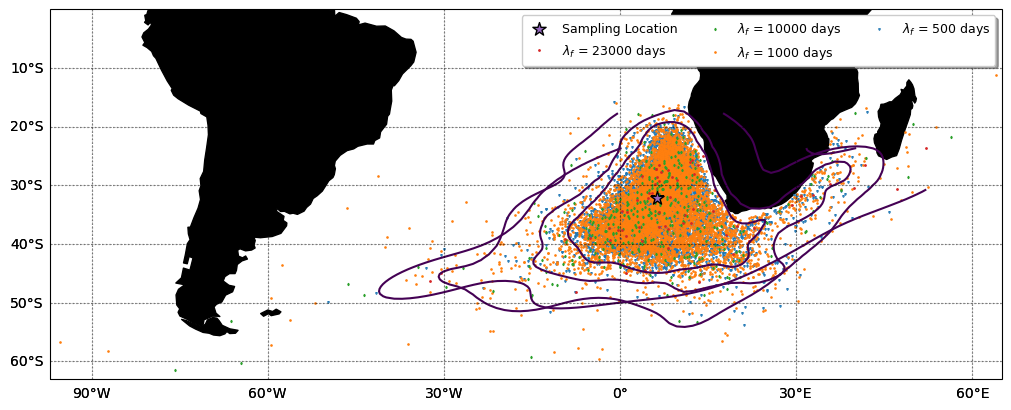

In [5]:
marker = itertools.cycle(('v', 'h', 'd', 'o', 'X', 'P', '^', 's'))

fig,ax = plt.subplots(figsize=(10,8),
                      subplot_kw={'projection': ccrs.PlateCarree()}, constrained_layout=True)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.3, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='black', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([0, 40,-60.916664, -20], crs=ccrs.PlateCarree())

# ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND, zorder=1, color='black')
# ax.add_feature(cfeature.COASTLINE)

for j, ft in enumerate(simulations):
    ax.scatter(surface_events[ft]['lon'], surface_events[ft]['lat'],
               zorder=2, s=1,
               label=f"$\lambda_f$ = {ft} days", marker=next(marker))

for j, ft in enumerate(simulations):
    x = surface_events[ft]['lon']
    y = surface_events[ft]['lat']

    # Perform a kernel density estimate on the data
    k = kde.gaussian_kde([x, y])
    xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    # Find density level that includes 90% of the particles
    zi_sorted = np.sort(zi.flatten())
    cumulative_zi = np.cumsum(zi_sorted)
    level = zi_sorted[np.where(cumulative_zi >= cumulative_zi[-1] * 0.05)[0][0]]

    # Plot contours at this density level
    ax.contour(xi, yi, zi.reshape(xi.shape), levels=[level], label=f"$\lambda_f$ = {ft} days")
    

ax.scatter(origin[0], origin[1], zorder=5,
           label='Sampling Location', marker='*', s=100, edgecolors='black')

# for r in range(1, 10):
#     circle_points = geodesic.Geodesic().circle(lon=origin[0], lat=origin[1],
#                                                radius=r*1e6,
#                                                n_samples=360,
#                                                endpoint=False)
#     geom = shapely.geometry.Polygon(circle_points)
#     ax.add_geometries((geom,), crs=ccrs.PlateCarree(), facecolor='none',
#                       edgecolor='black', linewidth=1., zorder=3, ls='--',
#                       label=f'{r} km')
# ax.text(3.3, -24.5, r"$1,000$ km", fontsize=5)
# ax.text(-14.5, -30.5, r"$2,000$ km", fontsize=5, rotation=70)
# ax.text(-25., -30.5, r"$3,000$ km", fontsize=5, rotation=70)
# ax.text(-35.6, -30.5, r"$4,000$ km", fontsize=5, rotation=70)
# ax.text(-46.6, -31.5, r"$5,000$ km", fontsize=5, rotation=70)
# ax.text(-63.5, -48.5, r"$6,000$ km", fontsize=5, rotation=75)
# ax.text(-79.3, -52.5, r"$7,000$ km", fontsize=5, rotation=62)
# ax.text(-89.5, -45.3, r"$8,000$ km", fontsize=5, rotation=53)
# ax.text(-89.5, -27.3, r"$9,000$ km", fontsize=5, rotation=55)

handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]


ax.set_extent([-97, 65, -63, 0], crs=ccrs.PlateCarree())

ax.legend(handles, labels, ncols=3, fontsize=9, shadow=True) 
# fig.savefig('../article_figs/Figure3.png', dpi=300,
#             facecolor=(1, 0, 0, 0))

In [51]:
mask = xr.open_dataset('/storage/shared/oceanparcels/input_data/MOi/domain_ORCA0083-N006/PSY4V3R1_mask.nc')
indices = {'lat': range(500, 1600), 'lon': range(2000, 4300)}
landmask = mask['tmask'][0, 0, indices['lat'], indices['lon']]
xlon = mask['nav_lon'][indices['lat'], indices['lon']].values
ylat = mask['nav_lat'][indices['lat'], indices['lon']].values

# mask the cell of the land == 0 

landmask = landmask.values
landmask = landmask.astype(bool)
landmask = landmask[::10, ::10]
xlon = xlon[::10, ::10]
ylat = ylat[::10, ::10]


In [60]:
griddata?

Signature:
griddata(
    points,
    values,
    xi,
    method='linear',
    fill_value=nan,
    rescale=False,
)
Docstring:
Interpolate unstructured D-D data.

Parameters
----------
points : 2-D ndarray of floats with shape (n, D), or length D tuple of 1-D ndarrays with shape (n,).
    Data point coordinates.
values : ndarray of float or complex, shape (n,)
    Data values.
xi : 2-D ndarray of floats with shape (m, D), or length D tuple of ndarrays broadcastable to the same shape.
    Points at which to interpolate data.
method : {'linear', 'nearest', 'cubic'}, optional
    Method of interpolation. One of

    ``nearest``
      return the value at the data point closest to
      the point of interpolation. See `NearestNDInterpolator` for
      more details.

    ``linear``
      tessellate the input point set to N-D
      simplices, and interpolate linearly on each simplex. See
      `LinearNDInterpolator` for more details.

    ``cubic`` (1-D)
      return the value determined from 

In [59]:
mask_interp = griddata((x.flatten(), y.flatten()), landmask.flatten(), (xlon, ylat), method='nearest')

ValueError: different number of values and points

In [62]:
landmask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [64]:
xi, yi = xlon, ylat
    
xi = xi.flatten()[landmask.flatten()]
yi = ylat.flatten()[landmask.flatten()]

zi = k(np.vstack([xi, yi]))

In [65]:
zi

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       1.01542260e-161, 3.80444299e-166, 9.66018740e-171])

In [73]:
zi.shape

(21104,)

In [76]:
110*230

25300

In [79]:
xi.shape

(21104,)

In [85]:
landmask.shape

(110, 230)

In [86]:
xlon.shape

(110, 230)

In [88]:
#mask values we

(21104,)

In [78]:
xi = xlon.ravel()[landmask.ravel()]
yi = ylat.ravel()[landmask.ravel()]

for j, ft in enumerate(simulations):
    x = surface_events[ft]['lon']
    y = surface_events[ft]['lat']

    # Perform a kernel density estimate on the data
    k = kde.gaussian_kde([x, y])

    zi = k(np.vstack([xi, yi]))

    # Find density level that includes 90% of the particles
    zi_sorted = np.sort(zi.flatten())
    cumulative_zi = np.cumsum(zi_sorted)
    level = zi_sorted[np.where(cumulative_zi >= cumulative_zi[-1] * 0.05)[0][0]]
    
    plt.contour(xlon, ylat, zi.reshape(xlon.shape), levels=[level])


/tmp/ipykernel_126289/1571012313.py:9: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde([x, y])


ValueError: cannot reshape array of size 21104 into shape (110,230)

In [57]:
zi_masked

array([7.84228013e-12, 1.52069692e-11, 2.90860963e-11, ...,
       2.03639350e-23, 2.08333125e-23, 2.10259448e-23])

In [41]:
# Plot contours at this density level
contours = ax.contour(xi, yi, zi.reshape(xi.shape), levels=[level])

# Get the contour lines
contour_lines = []
for collection in contours.collections:
    for path in collection.get_paths():
        contour_lines.append(path.vertices)


In [42]:
contour_lines

[array([[-79.02893468, -63.        ],
        [-79.        , -62.99703664],
        [-78.96741423, -63.        ]]),
 array([[-43.08414192, -49.        ],
        [-43.16340825, -48.36363636],
        [-43.        , -48.01745928],
        [-42.87936935, -47.72727273],
        [-42.35357771, -47.09090909],
        [-41.60377841, -46.45454545],
        [-41.36363636, -46.29681767],
        [-40.68234366, -45.81818182],
        [-39.72727273, -45.27667211],
        [-39.56489672, -45.18181818],
        [-38.2951485 , -44.54545455],
        [-38.09090909, -44.45427413],
        [-36.84926304, -43.90909091],
        [-36.45454545, -43.75051583],
        [-35.20688531, -43.27272727],
        [-34.81818182, -43.13120899],
        [-33.3558612 , -42.63636364],
        [-33.18181818, -42.57832397],
        [-31.54545455, -42.07056632],
        [-31.30196828, -42.        ],
        [-29.90909091, -41.58849721],
        [-29.10256787, -41.36363636],
        [-28.27272727, -41.12228536],
        [-

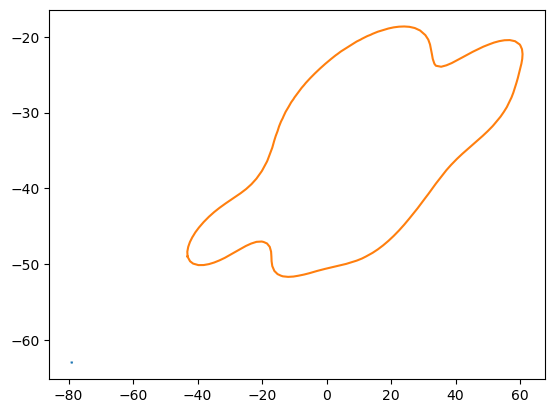

In [43]:
for line in contour_lines:
    plt.plot(line[:, 0], line[:, 1], label=f"$\lambda_f$ = {ft} days")